# **Vehicle detection** 
***
In this project we developed a procedure to detect vehicle from the video. Course work has detail explanation and step by step procedure to create a pipeline. We will achieve this goal by following steps

   - Extract bin spatial and histogram of colors as features
   - Perform Histogram of Oriented Gradients(HOG) features
   - Combine all three features and form a uber set of features
   - With labeled training set, train a Linear Support Vector Machine classifier(SVC) to detect car vs non-cars
   - With sliding window approach detect vehicle overlaping bounding boxes
   - Using heat map remove duplicates and avoid false positives
   - After detection of vehicle overlay with original image
   
Finally run with project video and produce results


Initializing camera calibration


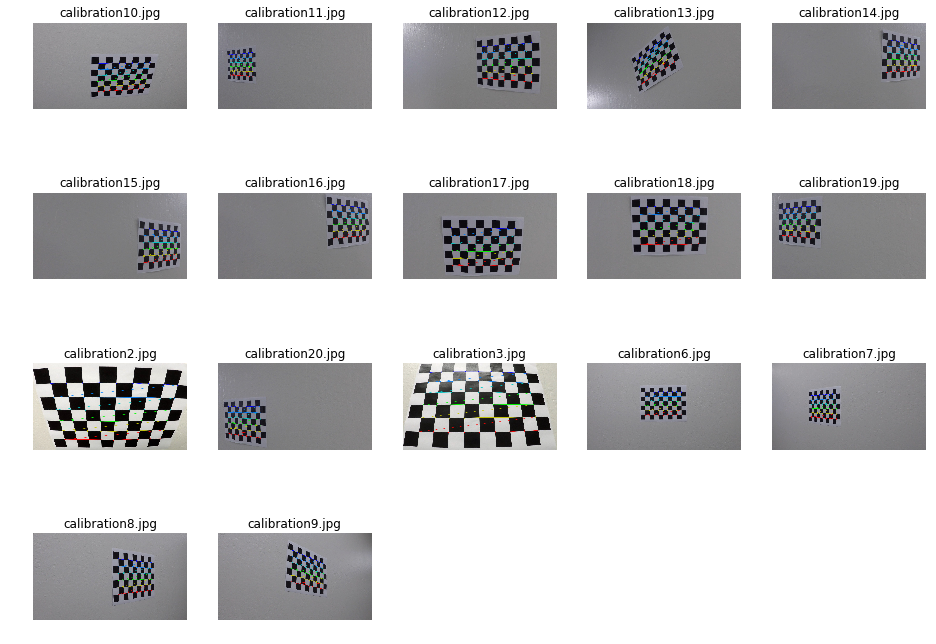

Calibration succesful


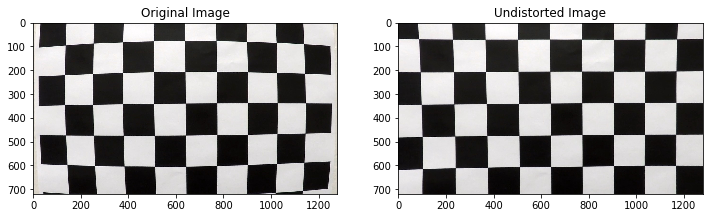

In [1]:
#importing some useful packages
import os, glob
import random
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import numpy as np
from AdvanceLaneLines import *
import cv2
from scipy.ndimage.measurements import label
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
%matplotlib inline

### **Utility API's** 
***
- convert_color converts from one color space to another color space
- get_hog_features retrieves HOG features from image
- bin_spatial creates features from color spectrum
- color_hist retrieves histogram from color spectrum
- extract_features retrieves features with given params like hog, spatial and color histogram
- slide_windows applies sliding window with starting co-ordinates and window size with overlaping percentage

In [2]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32, bins_range=(0, 256)):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



In [44]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # Read in each one by one
        #image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    #nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    #ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [51]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        #test_features = scaler.transform(np.hstack((features)).reshape(1, -1))
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #print("Test features:", test_features)
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        #print("Vehicle prediction:", prediction)
        if prediction == 1:
            
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

### Train data analysis
***

After data preparation and analysis, no need to augment any data to the dataset. Picked few samples randomly and analyzed their shape and sizes to train the model.

Did a color space analysis and found out that 'YCrCb' color space working well in this case. Following steps performed in order to extract features from dataset

- Performed histogram of car and non-car distribution
- Analyzed shape and size of the data
- Performed HOG feature extration using orient=9, color_space = 'YCrCb', pix_per_cell = 8, cell_per_block=2
- Omited spatial binning because there is no change in end results
- Omited color histogram features



Loading data ... 

Total 8792 car images loaded.
Total 8968 non car images loaded.

Single image has size (64, 64).
Single image has 3 colors.


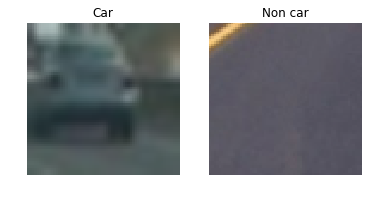

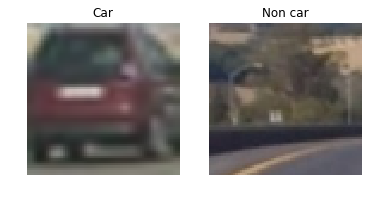

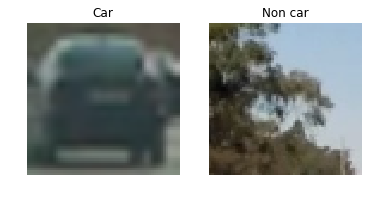

In [5]:
def load_train_data():
    car_img_dir = './traindata/vehicles/**/*.png'
    non_car_img_dir = './traindata/non-vehicles/**/*.png'
    car_glob = glob.glob(car_img_dir, recursive=True)
    non_car_glob = glob.glob(non_car_img_dir, recursive=True)
    print("Loading data ... ")
    car_images = np.array([mpimg.imread(fname) for fname in car_glob])
    non_car_images = np.array([mpimg.imread(fname) for fname in non_car_glob])
    print()
    print('Total {} car images loaded.'.format(car_images.shape[0]))
    print('Total {} non car images loaded.'.format(non_car_images.shape[0]))
    print()
    print('Single image has size {}.'.format(car_images.shape[1:3]))
    print('Single image has {} colors.'.format(car_images.shape[3]))
    return car_images, non_car_images

def visualize_sample_data(car_images, non_car_images):
    #plt.figure(figsize=(15,4))
    for idx in range(3):
        index = int(np.random.choice(100, 1))
        car = car_images[index]
        non_car = non_car_images[index]
        plt.subplot(1, 2, 1)
        plt.axis('off')
        plt.title('Car')
        plt.imshow(car)
        plt.subplot(1, 2, 2)
        plt.axis('off')
        plt.title('Non car')
        plt.imshow(non_car)
        plt.show()
    
    return
    
car_images, non_car_images = load_train_data()
visualize_sample_data(car_images, non_car_images)

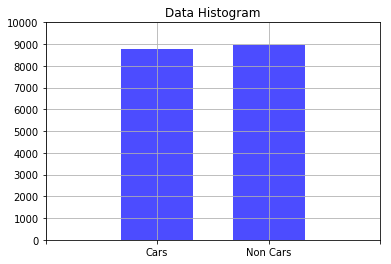

In [6]:
def train_data_histogram_display(car_images, non_car_images):
    xticks = np.arange(4)
    ind = xticks[1:3]
    width = 0.65

    data_counts = (len(car_images), len(non_car_images))
    plt.bar(ind, data_counts, width, facecolor='blue', alpha=0.7, align='center')
    plt.xticks(xticks, ('', 'Cars', 'Non Cars', ''))
    plt.yticks(np.arange(0, int(1.2*max(data_counts)), 1000))
    plt.grid(True)
    plt.title('Data Histogram')

    plt.show()
    return

train_data_histogram_display(car_images, non_car_images)

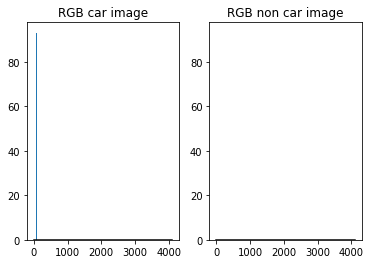

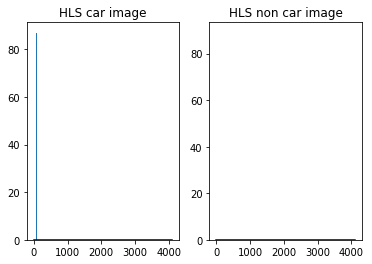

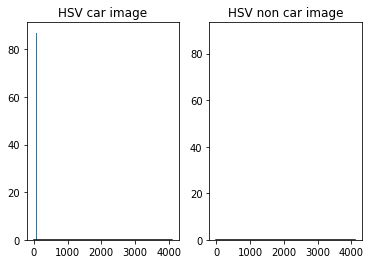

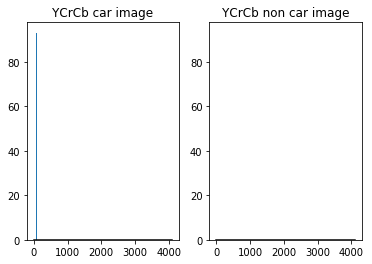

In [7]:
def train_data_color_hist_display():
    index = int(np.random.choice(100, 1))
    temp_car_images = np.array([car_images[index]])
    temp_non_car_images = np.array([non_car_images[index]])
    colorspaces = ["RGB", "HLS", "HSV", "YCrCb"]
    for color_space in colorspaces:
        car_features = extract_features(temp_car_images, color_space, spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=False, hist_feat=True, hog_feat=False)
        non_car_features = extract_features(temp_non_car_images, color_space, spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=False, hist_feat=True, hog_feat=False)
        n_bins = 25
        avg_samples_per_bin = len(car_features)/n_bins
        hist, bins = np.histogram(car_features, n_bins)
        center = (bins[:-1]+bins[1:])/2
        plt.subplot(1, 2, 1)
        plt.bar(center, hist, align='center')
        plt.plot((np.min(car_features), np.max(car_features)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
        plt.title(color_space+' car image')
        
        avg_samples_per_bin = len(non_car_features)/n_bins
        hist, bins = np.histogram(non_car_features, n_bins)
        center = (bins[:-1]+bins[1:])/2
        plt.subplot(1, 2, 2)
        plt.bar(center, hist, align='center')
        plt.plot((np.min(non_car_features), np.max(non_car_features)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
        plt.title(color_space+' non car image')
        #channels = car_features.shape[0]

        #plt.figure(figsize=(15,4))
        #for idx in range(channels):
        #    plt.subplot(1, 3, idx+1)
        #    plt.title(color_space)

            # compute bar center using bin ranges
        #    x_ticks = car_features[idx][1][1:] - car_features[idx][1][1]/2
        #    plt.plot(x_ticks, car_features[idx][0], 'b', label='Car')
        #    plt.plot(x_ticks, non_car_features[idx][0], 'r', label='Non-Car')
        #    plt.legend()
        #    plt.tight_layout()
        plt.show()
        
    return
#testing different color space
train_data_color_hist_display()

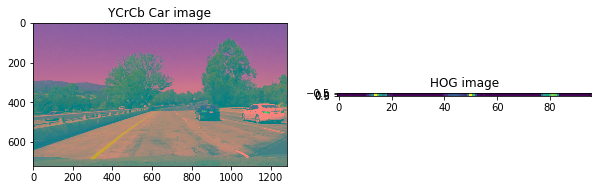

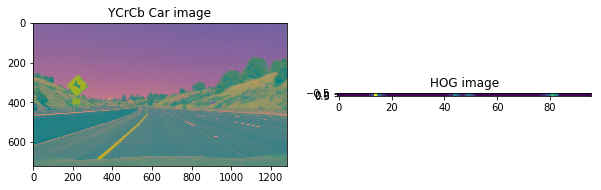

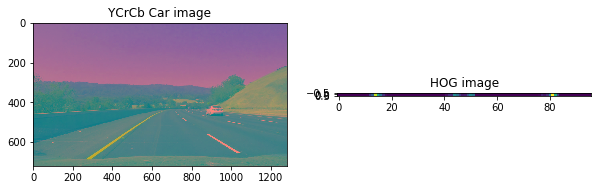

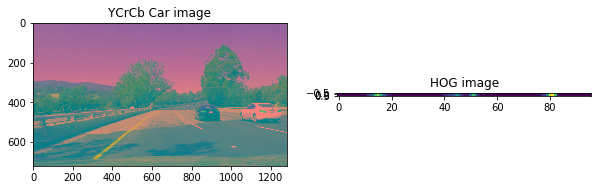

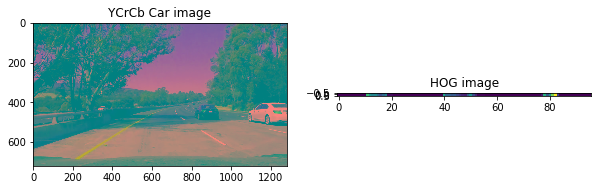

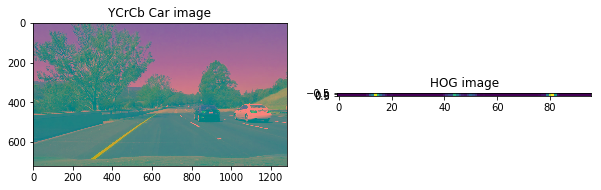

In [8]:
def test_color_and_hog():
    test_images = glob.glob('./test_images/*.jpg')
    for filename in test_images:
        img = plt.imread(filename)
        #default YCrCb color space
        img = convert_color(img)
        color_space = 'YCrCb'
        car_features = extract_features(np.array([img]), color_space, spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=False, hist_feat=True, hog_feat=False)
        plt.figure(figsize=(10,4))

        plt.subplot(1, 2, 1)
        plt.title("YCrCb Car image")
        plt.imshow(img)

        plt.subplot(1, 2, 2)
        plt.title("HOG image")
        plt.imshow(car_features)
        plt.show()

test_color_and_hog()

### Train model
***
After data evaluation picked up color space 'YCrCb' with HOG params mentioned in the code. All these parameters tuned with trail and error. Did following steps to train the model

  - Extracted HOG features from car and non car dataset. 
  - Experimented with color histogram and spatial binning, didn't improve final results
  - Normalized the data
  - Trained the Linear Support Vector Machine classifier with default parameters.
  - Validated trained model with validation set and conducted prediction tests
  
It can be tuned but current implementaiton of SVC predicting 98% accuracy



In [9]:
def train_model(cars, non_cars):
    
    ### TODO: Tweak these parameters and see how the results change.
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = False # Spatial features on or off
    hist_feat = False # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [None, None] # Min and max in y to search in slide_window()

    print("Extracting features on train data ... ")
    t=time.time()
    car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    #car_features2 = extract_features(cars, color_space=color_space, 
    #                    spatial_size=spatial_size, hist_bins=hist_bins, 
    #                    orient=orient, pix_per_cell=pix_per_cell, 
    #                    cell_per_block=cell_per_block, 
    #                    hog_channel=2, spatial_feat=spatial_feat, 
    #                    hist_feat=hist_feat, hog_feat=hog_feat)
    #car_features = np.concatenate((car_features1, car_features2))
    
    non_car_features = extract_features(non_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    #non_car_features2 = extract_features(non_cars, color_space=color_space, 
    #                    spatial_size=spatial_size, hist_bins=hist_bins, 
    #                    orient=orient, pix_per_cell=pix_per_cell, 
    #                    cell_per_block=cell_per_block, 
    #                    hog_channel=2, spatial_feat=spatial_feat, 
    #                    hist_feat=hist_feat, hog_feat=hog_feat)
    #non_car_features = np.concatenate((car_features1, car_features2))
    
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract features ...')
    X = np.vstack((car_features, non_car_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    
    t=time.time()
    n_predict = 10
    print('SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('Labels for these ',n_predict, ' predictions : ', y_test[0:n_predict])
    t1 = time.time()
    print(round(t1-t, 5), 'Seconds to predict', n_predict,' labels with SVC')

    return svc, X_scaler

def test_prediction(svc):
    # Check the prediction time for a single sample
    t=time.time()
    image = mpimg.imread('./test_images/test1.jpg')
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    #image = image.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    return

svc, X_scaler = train_model(car_images, non_car_images)

Extracting features on train data ... 
59.22 Seconds to extract features ...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
21.77 Seconds to train SVC...
Test Accuracy of SVC =  0.9803
SVC predicts:  [ 0.  0.  1.  0.  0.  1.  0.  1.  1.  0.]
Labels for these  10  predictions :  [ 0.  0.  1.  0.  0.  1.  0.  1.  1.  0.]
0.01825 Seconds to predict 10  labels with SVC


### Detecting cars with sliding window
***
Sliding window approach used to detect cars. In this step we pick a small region in the image and slide with certain overlapping percentage. Also for efficiency purpose, instead of picking entire image, picked a region of interest where cars appears in the image like bottom of the image. 
For each region extracted HOG features and classify it. If Linear classifier detect the region as car, we will mark those regions. Picked all possible windows in which some of them may be false positives.

Different window size and overlap percentage will be used to improve accuracy of detection. These are main steps in the process

- Normalize the image data 
- Region of interest like bottom of the image 
- Overlap percentage 
- Each region extracted HOG features
- predict car vs non-car with Linear SVM classifier
- All classifier predicted regions will be marked and forward it to remove false positives

Tried with optimized version of find_cars method from lecture notes but it didn't perform well. I end up using old style sliding window which is much better but need to revisit this logic one more time why it's not performing well.

**Note: After experimenting with multiple windows with different overlap ratios didn't improve vehicle detection. Stick with one window and increased overlap ratio, which solved the problem. I stick with one window based on lecture notes from optimized version of window search.  

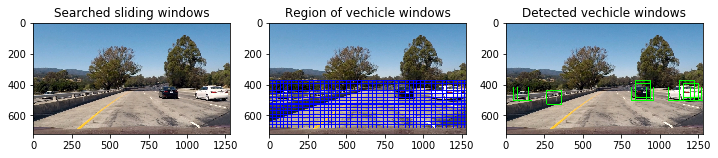

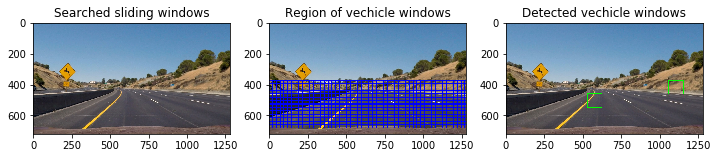

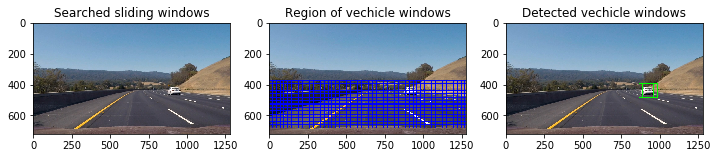

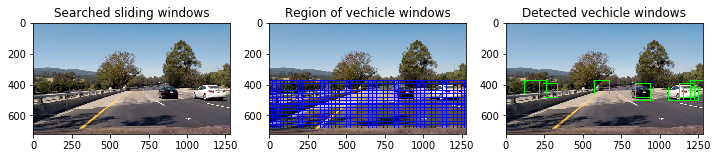

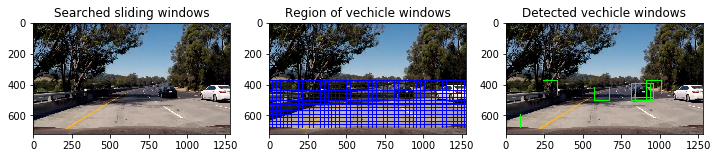

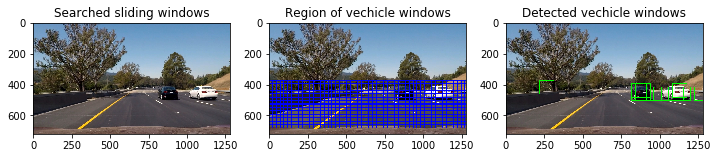

In [56]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins, drawBox=False):
    bbox_list = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    #ctrans_tosearch = np.copy(img_tosearch)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    t = time.time()
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    t1 = time.time()
    if drawBox:
        print(round(t1-t, 2), 'Seconds to retrieve hog features...')
        print("Nxsteps:", nxsteps, ", Nysteps:" + nysteps)
    bbox_all_list=[]
    
    t = time.time()
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            #test_features = np.array(test_features).astype(np.float64)
            test_prediction = svc.predict(test_features)
            
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            bbox = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                
            if test_prediction == 1:
                bbox_list.append(bbox)

            bbox_all_list.append(bbox)
    t1 = time.time()      
    if drawBox:
        print(round(t1-t, 2), 'Seconds to detect windows ...')
        draw_img_detected = np.copy(draw_img)
        # draw all all searched windows
        for bbox in bbox_all_list:
            cv2.rectangle(draw_img, bbox[0], bbox[1], (0,0,255), 3) 
        for bbox in bbox_list:
            cv2.rectangle(draw_img_detected, bbox[0], bbox[1], (0,0,255), 3) 

        plt.figure(figsize=(12,8))
        plt.subplot(1, 2, 1)
        plt.imshow(draw_img)
        plt.title('Searched sliding windows')
        plt.subplot(1, 2, 2)
        plt.imshow(draw_img_detected, cmap='hot')
        plt.title('Detected vechicle windows')
        plt.show()

                
    return bbox_list

def extract_sub_imgs(img, windows):
    sub_imgs = []

    for win in windows:
        xstart, xstop = win[0][0], win[1][0]
        ystart, ystop = win[0][1], win[1][1]
        sub_img = img[ystart:ystop,xstart:xstop,:]
        sub_img = cv2.resize(sub_img, (64,64))
        sub_imgs.append(sub_img)

    return np.array(sub_imgs)

def find_cars_by_sliding_window(img, ystart, ystop, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins, drawBox=False):
    w, h = img.shape[1], img.shape[0]
    #draw_img = np.copy(img)
    norm_img = img.astype(np.float32)/255
    '''
    y_start_stop_top = [np.int(0.5*h), np.int(0.65*h)]
    y_start_stop_mid = [np.int(0.51*h), np.int(0.75*h)]
    y_start_stop_low = [np.int(0.65*h), np.int(0.91*h)]
    print ("Top :", y_start_stop_top, ", mid:", y_start_stop_mid, ", low:", y_start_stop_low)
    win_top = slide_window(norm_img,
                           x_start_stop=[None, None],
                           y_start_stop=[np.int(0.5*h), np.int(0.65*h)],
                           xy_window=(80, 80),
                           xy_overlap=(0.8, 0.8))

    win_mid = slide_window(norm_img,
                           x_start_stop=[None, None],
                           y_start_stop=[np.int(0.51*h), np.int(0.75*h)],
                           xy_window=(96, 96),
                           xy_overlap=(0.75, 0.75))

    win_low = slide_window(norm_img,
                           x_start_stop=[None, None],
                           y_start_stop=[np.int(0.65*h), np.int(0.91*h)],
                           xy_window=(128, 128),
                           xy_overlap=(0.7, 0.7))
    windows = []
    if len(win_top) > 0:
        windows.extend(win_top)
    if len(win_mid) > 0:
        windows.extend(win_mid)
    if len(win_low) > 0:
        windows.extend(win_low)
    #print("Top win:", win_top, ", Mid win:", win_mid, ", Low win:", win_low);
    #print ("Windows:", windows)
    
    #top_imgs = extract_sub_imgs(img, win_top)
    #mid_imgs = extract_sub_imgs(img, win_mid)
    #low_imgs = extract_sub_imgs(img, win_low)
    
    #print("Top:", top_imgs.shape, ", Mid:", mid_imgs.shape, ", Low:", low_imgs.shape)
    
    temp_list = []
    if len(top_imgs) > 0:
        temp_list.append(top_imgs)
    if len(mid_imgs) > 0:
        temp_list.append(mid_imgs)
    if len(low_imgs) > 0:
        temp_list.append(low_imgs)
        
    #sub_images = np.concatenate(temp_list)
    sub_imgs = np.concatenate((top_imgs, mid_imgs, low_imgs), axis=0)

    #print("Final shape:", sub_images.shape)
    hog_features = extract_features(sub_images, color_space='YCrCb', spatial_size=(32, 32),
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel='ALL',
                        spatial_feat=False, hist_feat=False, hog_feat=True)
    X = np.array(hog_features).astype(np.float64)
    scaled_features = X_scaler.transform(X)
    
    pred = svc.predict(scaled_features)
    car_indexes = np.nonzero(pred)
    car_boxes = np.asarray(np.concatenate((temp_list)))[car_indexes]
    '''
    
    windows = slide_window(norm_img,
                           x_start_stop=[None, None],
                           y_start_stop=(ystart, ystop),
                           xy_window=(96, 90),
                           xy_overlap=(0.75, 0.75))
    
    #print("Windows :", windows)
    hot_windows = search_windows(norm_img, windows, svc, X_scaler, color_space='YCrCb', 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel='ALL', spatial_feat=False, 
                        hist_feat=False, hog_feat=True)
    
    #window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    #print ("Car boxes:", hot_windows)
    if drawBox:
        draw_img = np.copy(img)
        # draw all all searched windows
        draw_img = draw_boxes(draw_img, windows, color=(0, 0, 255), thick=4)
        draw_img1 = draw_boxes(img, hot_windows, color=(0, 255, 0), thick=4)
        #draw_img = draw_boxes(draw_img, win_low, color=(255, 0, 0), thick=4)
            
        plt.figure(figsize=(12,8))
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title('Searched sliding windows')
        plt.subplot(1, 3, 2)
        plt.imshow(draw_img, cmap='hot')
        plt.title('Region of vechicle windows')
        plt.subplot(1, 3, 3)
        plt.imshow(draw_img1, cmap='hot')
        plt.title('Detected vechicle windows')
        plt.show()
        
    return hot_windows

def test_find_cars():
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    #hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (64, 64) # Spatial binning dimensions
    hist_bins = 32 
    
    ystart = 370
    ystop = 650
    scale = 1
    test_glob = glob.glob('./test_images/*.jpg')
    for imname in test_glob:
        img = plt.imread(imname)
        #bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
        #                cell_per_block, spatial_size, hist_bins, True)
        bbox_list = find_cars_by_sliding_window(img, ystart, ystop, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins, drawBox=True)
    return

test_find_cars()

### Removing duplicates and false positives
***
Heat maps are used to remove duplicate and false positives. Conducted following steps

 - Intialized heat map with dimension equal to the input image
 - Add +=1 to the heat map pixels where classifier detected it as car
 - hot parts of the areas are extracted by applying thresholds which internally removes false positives
 - Also introduced caching of previously detected heat map to smooth out detection boundries

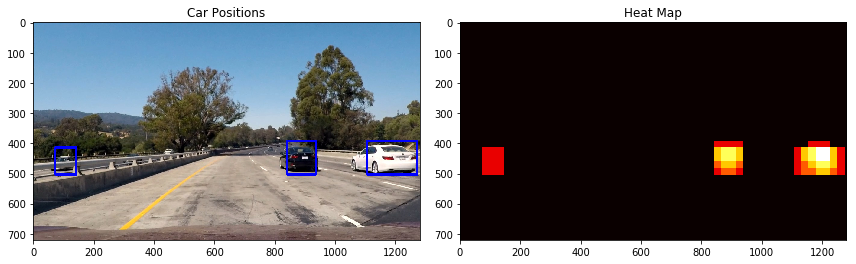

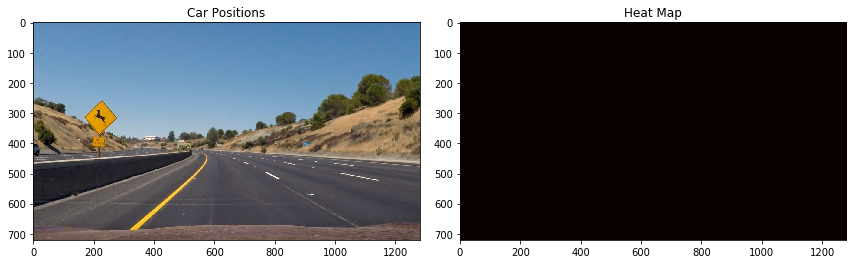

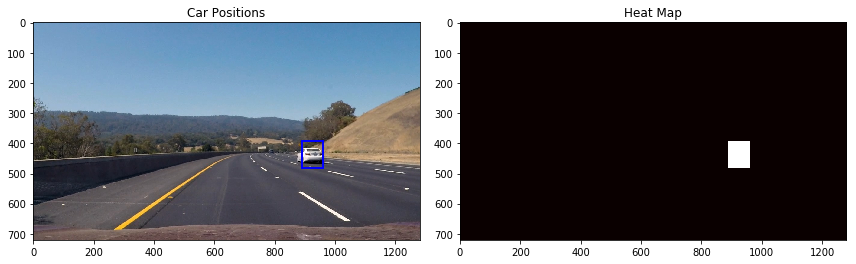

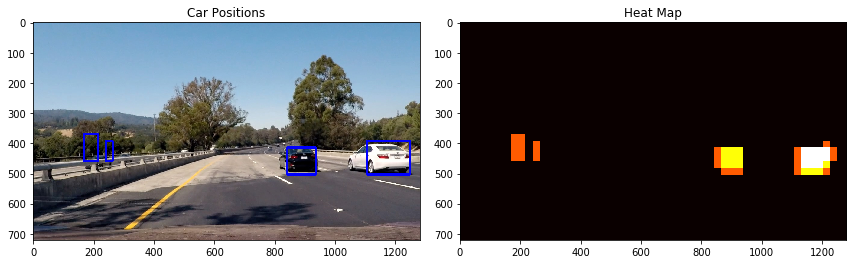

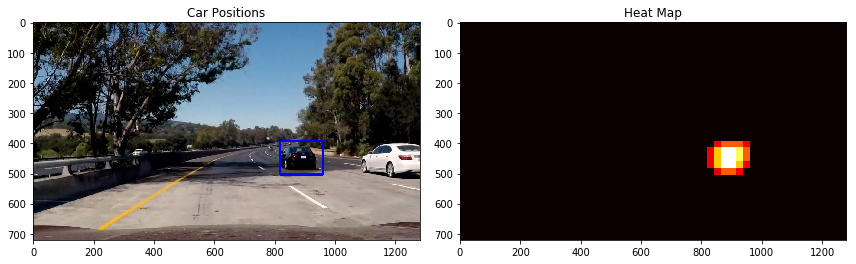

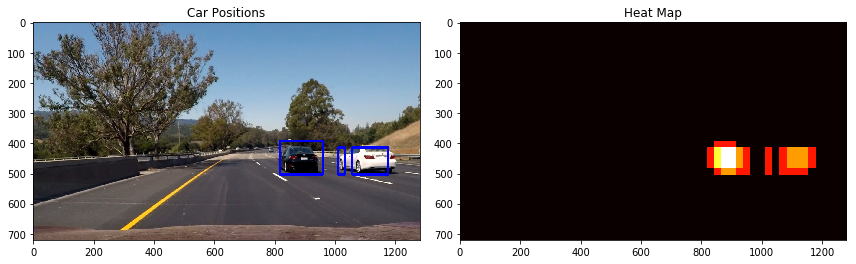

In [57]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def test_heat_map():
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (64, 64) # Spatial binning dimensions
    hist_bins = 32
    
    # Read test images
    test_glob = glob.glob('test_images/*.jpg')
    
    for imname in test_glob :
        image = mpimg.imread(imname)
        ystart = 370
        ystop = 650
        scale = 1
        #bbox_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
        #                cell_per_block, spatial_size, hist_bins, False)
        bbox_list = find_cars_by_sliding_window(image, ystart, ystop, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins, drawBox=False)
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        # Add heat to each box in box list
        heat = add_heat(heat,bbox_list)
    
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,1)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)

        fig = plt.figure(figsize=(12,8))
        plt.subplot(121)
        plt.imshow(draw_img)
        plt.title('Car Positions')
        plt.subplot(122)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()
        
    return

test_heat_map()


### Overall pipeline
***
Overall pipeline consists of vehicle detection and advanced lane detection together. It require a further tuning in sliding window algorithm, which is consuming most of the time in pipeline.

In [59]:
from collections import deque

heat_map_history = deque(maxlen=8)

def vehicle_detection(image):
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 32 
    
    ystart = 400
    ystop = 600
    scale = 1
    #bbox_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
    #                    cell_per_block, spatial_size, hist_bins)
    bbox_list = find_cars_by_sliding_window(image, ystart, ystop, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins, drawBox=False)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)
    heat_map_history.append(heat)
    
    heat_list = []
    for temp in heat_map_history:
        heat_list.append(temp)
    heat_map = np.sum(heat_list, axis=0)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat_map,1)

    # Visualize the heatmap when displaying    
    #heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heat)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    #advance lane detection from previous project
    draw_img = advance_lane_detection(draw_img)
    return draw_img


In [60]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [61]:
white_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(vehicle_detection) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [41:17<00:01,  1.96s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 40min 29s, sys: 1min 53s, total: 42min 23s
Wall time: 41min 18s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [62]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Conclusion

This project is always fun to work. But I didn't get much time to tune couple of parameters. These are the things which I should revisit one more time
- Sliding window display is not smooth. Which require cache if the frame is same
- In the middle of the video one place it didn't detect car.
- Current implementation of pipeline is pretty slow, need to revisit and implement it one more time
- Also need to look at why spatial binning and color histogram didn't play much role in classifying